# Projecc

Project is a small simple pacakge for converting from orbital elements to on-sky projection and vice versa.  It is only for two-body systems and treats the system as a test mass orbiting a central object with total mass = M1 + M2.

In [1]:
from projecc import *
import astropy.units as u

# Set up system masses:
Mstar1 = 1.5*u.Msun
Mstar2 = 0.3*u.Msun
# Compute Kepler's constant 
kep = KeplersConstant(Mstar1,Mstar2)

# Draw 500 random orbits from orbital parameter priors:
# semi-major axis: LogUnif[LowerBound,UpperBound]
# eccentricity: Unif[0,1] or Linearly Descending
# inclination: cos(inc) Unif[-1,1]
# argument of periastron: Unif[0,2pi]
# longitude of nodes: Unif[0,2pi]
# mean anomaly: Unif[0,2pi]

Nsamples = 500
sma, ecc, inc, argp, lon, meananom = DrawOrbits(Nsamples)

In [2]:
# Compute 3d position, velocity, and acceleration for each random orbit:
pos, vel, acc = KeplerianToCartesian(sma,ecc,inc,argp,lon,meananom,kep)
# pos (3xN arr) [au]: position in xyz coords in au, with 
#                        x = pos[0], y = pos[1], z = pos[2] for each of N orbits
#                        +x = -RA, +y = +Dec, +z = towards observer (NOTE: this is reverse from 
#                                                          the RV convention of +z = away from observer)
# vel (3xN arr) [km/s]: velocity in xyz plane.
# acc (3xN arr) [km/s/yr]: acceleration in xyz plane.

pos

<Quantity [[  569.67252892, -1161.80478927,  -746.39515167],
           [  -11.70946309,   -10.05826864,    -1.37475168],
           [ -315.70132772,   101.18547518,    60.02926909],
           ...,
           [  227.98005554,   528.15086203,    -8.53236647],
           [ -203.66109216,   517.8287406 ,  -150.80497832],
           [  453.07530596,   380.88663307,    53.53352939]] AU>

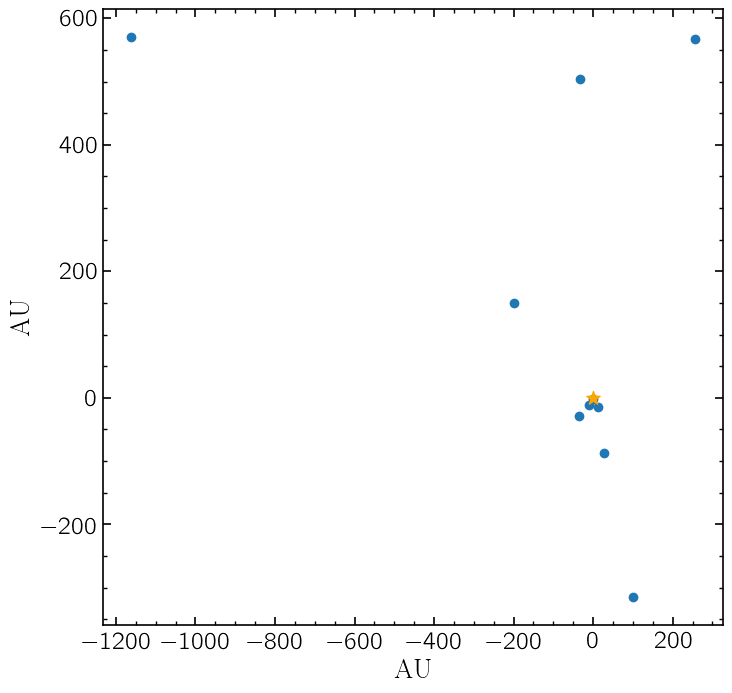

In [3]:
# here is a plot of inital position of the first 10 random orbits in on-sky RA/Dec:
plt.figure(figsize = (8,8))
plt.scatter(0,0, marker = '*', color='orange', s=100, zorder=10)
plt.scatter(pos[:10,1],pos[:10,0])
plt.xlabel('AU')
plt.ylabel('AU')
plt.show()

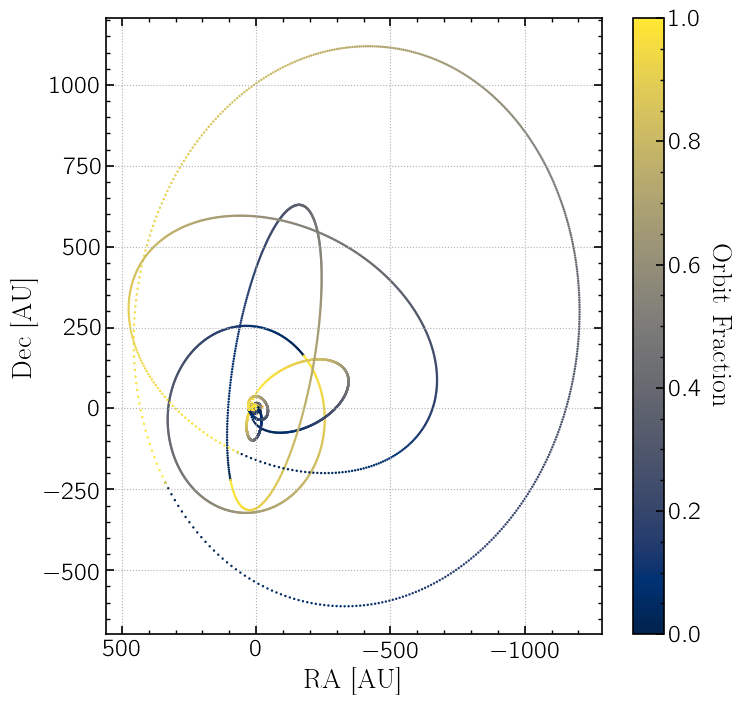

In [4]:
# Plot of the first 10 full orbit tracks in the plane of the sky:
cmap = 'cividis'
# Set number of points along a track to plot:
Npoints = 500
# Set up figure:
plt.figure(figsize = (8,8))
# Plot location of central object
plt.scatter(0,0, marker = '*', color='orange', s=100)
# For each orbit:
for i in range(10):
    # Get N points along the tracks
    Xs, Ys = GetOrbitTracks(sma[i], ecc[i], inc[i], argp[i], lon[i], kep, Npoints = Npoints)
    taus = np.linspace(0,1,Npoints)
    # Plot:
    plt.scatter(Ys, Xs, c=taus, cmap=cmap, s=3, lw=0)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Orbit Fraction', rotation=-90, va="bottom")
# Reverse x-axis for RA increasing to the left:
plt.gca().invert_xaxis()
plt.xlabel('RA [AU]')
plt.ylabel('Dec [AU]')
plt.grid(ls=':')
plt.show()



#### To go from pos and vel back to orbital elements:

Returns: sma, ecc, inc, argp, lon.value, M

NOTE: You must have 3D information for both position and velocity.

In [5]:
# For the first random orbit:
CartesianToKeplerian(pos[0], vel[0], kep)

(<Quantity 987.22692043 AU>,
 <Quantity 0.52571339>,
 <Quantity 30.11634052 deg>,
 <Quantity 102.26110369 deg>,
 <Quantity 20.0728633 deg>,
 <Quantity 2.80791874>)

#### Note: as of now it can only handle one orbit at a time. If you need to compute for several orbits use a for loop

#### Using astropy units let you put quantites in any unit and does the conversions for you:

In [14]:
sep_meters = 1.9e11*u.m
sep_au = sep_meters.to(u.AU).value
print(period(sep_meters,Mstar1+Mstar2))
print(period(sep_au,Mstar1+Mstar2))

1.0668565570887611
1.0668565570887611


#### Mean Anomaly is the fraction of a circular orbit completed (in radians) at a given time point.  T$_0$ is the time of periastron passage, defined as Mean Anom = 0, in years.  To convert from a given Mean Anom to  T$_0$:

In [2]:
Period = period(sma*u.AU,Mstar1+Mstar2)
t0 = MeanAnomToT0(meananom, Period, RefEpoch = 2016, AfterDate = 2016)
t0[0]

2634.1243550310683

#### To randomly draw separation and position angle (r,$\phi$):

In [3]:
r, phi = DrawSepAndPA(Nsamples, Mstar1, Mstar2, DrawSMA = False, FixedSMA = 10.*u.AU)
r.shape,phi.shape

((500,), (500,))

# Eample:
### Prediciting the location of Sirius B relative to Sirius A over time

In [2]:
from projecc import *

In [6]:
# Orbital elements and uncertainties from Bond et al 2017: https://iopscience.iop.org/article/10.3847/1538-4357/aa6af8/pdf
Per = [50.1284,0.0043]
sma = [7.4957,0.0025] # arcsec
inc = [136.336,0.040]
lan = [45.4,0.071]
T0 = [1994.5715,0.0058]
ecc = [0.59142,0.00037]
argp = [149.161,0.075]
# masses
MA = [2.063,0.023]
MB = [1.018,0.011]


#  Obsdate must be in decimal year, we can use astropy time object to convert. 
# Let's observe on August 15th 2025.
from astropy.time import Time
obsdate = Time('2025-08-15T00:00:00')
obsdate =  obsdate.decimalyear
# Convert time of periastron passage and observation date to mean anomaly: 
meananom = T0ToMeanAnom(MonteCarloIt(T0),
                        MonteCarloIt(Per), 
                        RefEpoch = obsdate)

In [7]:
### We'll use the Monte Carlo method to propigate errors throughout the calculation:
# Set up array of system masses:
Mstar1 = MonteCarloIt(MA)*u.Msun
Mstar2 = MonteCarloIt(MB)*u.Msun
# Compute Kepler's constant 
kep = KeplersConstant(Mstar1,Mstar2)

In [13]:
# The sma is given in arcsecs, so if we put arcsecs in our output will also be in arcsecs

#Compute 3d position, velocity, and acceleration for each random orbit:
pos, vel, acc = KeplerianToCartesian(MonteCarloIt(sma),
                                     MonteCarloIt(ecc),
                                     MonteCarloIt(inc),
                                     MonteCarloIt(argp),
                                     MonteCarloIt(lan),
                                     meananom,kep)

In [14]:
# Compute separation and position angle at observation date: 
r,phi = GetSepAndPA(pos)
sep = [np.mean(r),np.std(r)]
pa = [np.mean(phi),np.std(phi)]
sep,pa

([10.951494569793832, 0.00467154646551167],
 [305.9073713834072, 0.09162820208660867])

In [15]:
# For the orbit through time at multiple observation dates:
obsdates = [1997, 2001, 2010, 2014, 2016, 2020, 2025.5, 2027.5]
seps, pas = [], []
decs_sig, ras_sig = [], []
decs, ras = [], []
for date in obsdates:
    meananom = T0ToMeanAnom(MonteCarloIt(T0),
                        MonteCarloIt(Per), 
                        RefEpoch = date)

    pos, vel, acc = KeplerianToCartesian(MonteCarloIt(sma),
                                     MonteCarloIt(ecc),
                                     MonteCarloIt(inc),
                                     MonteCarloIt(argp),
                                     MonteCarloIt(lan),
                                     meananom,kep)
    r,phi = GetSepAndPA(pos)
    sep = [np.mean(r),np.std(r)]
    pa = [np.mean(phi),np.std(phi)]
    seps.append(sep[0])
    pas.append(pa[0])
    dec = pos[:,0]
    ra = pos[:,1]
    decs.append(np.mean(dec))
    decs_sig.append(np.std(dec))
    ras.append(np.mean(ra))
    ras_sig.append(np.std(ra))

ras = np.array([ra.value for ra in ras])
decs = np.array([dec.value for dec in decs])
ras_sig = np.array([ra.value for ra in ras_sig])
decs_sig = np.array([dec.value for dec in decs_sig])

In [16]:
# Compute an orbit track by supplying a finer arrays of dates:
orbobsdates = np.linspace(T0[0],T0[0]+Per[0],100)
orbdecs, orbras = [], []
for date in orbobsdates:
    meananom = T0ToMeanAnom(T0[0],
                        Per[0], 
                        RefEpoch = date)

    pos, vel, acc = KeplerianToCartesian(sma[0],
                                     ecc[0],
                                     inc[0],
                                     argp[0],
                                     lan[0],
                                     meananom,np.mean(kep))
    orbdecs.append(pos[0].value)
    orbras.append(pos[1].value)

Text(0, 0.5, 'DEC ["]')

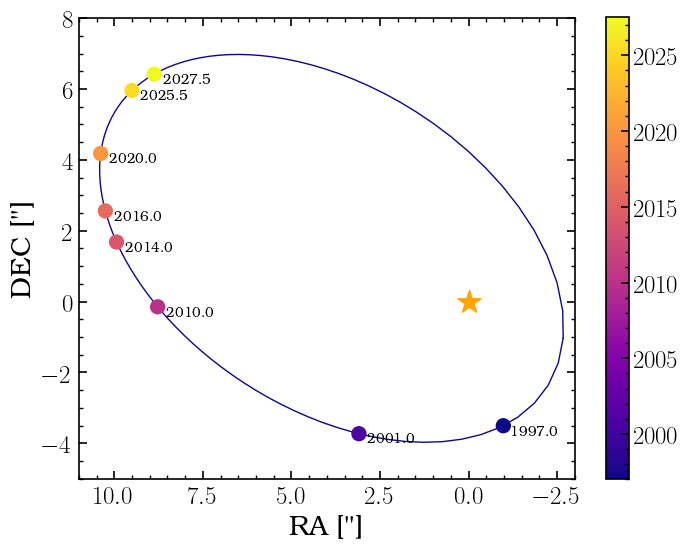

In [18]:
# Compare to Bond+ 2017 Figure 4:

plt.plot(orbras,orbdecs, lw=1)
plt.scatter(0,0, marker='*', color='orange', s=300)
plt.scatter(ras,decs, c=obsdates, s=100, zorder=10)
plt.colorbar()
for i in range(len(obsdates)):
    plt.annotate('{:.1f}'.format(obsdates[i]), xy = (ras[i],decs[i]), xytext = (6,-6), textcoords='offset points')


plt.ylim(-5,8)
plt.xlim(-3,11)
plt.gca().invert_xaxis()
plt.gca().set_aspect('equal')
plt.xlabel('RA ["]')
plt.ylabel('DEC ["]')